# Community Finding - Algorithm Comparision
## Jake Carlson

## Load Data

In [87]:
import numpy as np
import pandas as pd
import igraph
import uuid
import matplotlib.pyplot as plt

In [70]:
df_q = pd.read_csv("./data/2008-questions.csv")
df_a = pd.read_csv("./data/2008-answers.csv")
df_t = pd.read_csv("./data/2008-tags.csv")

# remove NaN owner ids
df_q = df_q[np.isfinite(df_q.OwnerUserId.values)]
df_a = df_a[np.isfinite(df_a.OwnerUserId.values) & df_a.ParentId.isin(df_q.Id)]

df_q.OwnerUserId = df_q.OwnerUserId.astype(np.int)
df_a.OwnerUserId = df_a.OwnerUserId.astype(np.int)

df_q['qid'] = [str(uuid.uuid4()) for _ in range(len(df_q))]
df_a['qid'] = [df_q['qid'].values[df_q.Id == a][0] for a in df_a.ParentId.values]

In [71]:
owner_to_uid = {}
def get_uids(df):
    uids = []
    for i, r in df.iterrows():
        owner = r['OwnerUserId']
        uid = None
        if owner in owner_to_uid.keys():
            uid = owner_to_uid[owner]
        else:
            uid = str(uuid.uuid4())
            owner_to_uid[owner] = uid
        uids.append(uid)
    return uids

df_q['uid'] = get_uids(df_q)
df_a['uid'] = get_uids(df_a)

In [72]:
df_q.head()

,Id,OwnerUserId,CreationDate,Score,Title,qid,uid
0,80,26,2008-08-01T13:57:07Z,26,SQLStatement.execute() - multiple queries in o...,5ef5de3d-5329-483c-ae6d-a25f8761d9ba,b424ee67-f316-4771-8fc6-ef78e2c2fe44
1,90,58,2008-08-01T14:41:24Z,144,Good branching and merging tutorials for Torto...,f990b00f-94c2-4928-9347-112cd020d1f5,7649c6ea-a965-424a-bccb-2879df0bd6bd
2,120,83,2008-08-01T15:50:08Z,21,ASP.NET Site Maps,03334b31-8f56-4fc1-ac95-22d486abe1f6,db6078d0-7be4-4317-8fdd-c45b90219ea1
3,180,2089740,2008-08-01T18:42:19Z,53,Function for creating color wheels,8082f437-a9be-4fd1-ad7b-eb9883e39ae5,dde44f8f-b693-4048-9e06-993cce7bd17d
4,260,91,2008-08-01T23:22:08Z,49,Adding scripting functionality to .NET applica...,de6df771-68bf-4f06-9b57-a8d93fd2be23,5b5d50ed-700a-4154-ad00-591f65822f95


In [73]:
df_a.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,qid,uid
0,92,61,2008-08-01T14:45:37Z,90,13,f990b00f-94c2-4928-9347-112cd020d1f5,2dd78e9b-684b-4490-95fe-8eebf56dd6ff
1,124,26,2008-08-01T16:09:47Z,80,12,5ef5de3d-5329-483c-ae6d-a25f8761d9ba,b424ee67-f316-4771-8fc6-ef78e2c2fe44
2,199,50,2008-08-01T19:36:46Z,180,1,8082f437-a9be-4fd1-ad7b-eb9883e39ae5,5514769b-3b49-4e02-9067-36148116f1ed
3,269,91,2008-08-01T23:49:57Z,260,4,de6df771-68bf-4f06-9b57-a8d93fd2be23,5b5d50ed-700a-4154-ad00-591f65822f95
4,307,49,2008-08-02T01:49:46Z,260,28,de6df771-68bf-4f06-9b57-a8d93fd2be23,bc0e0074-98ba-4154-a02c-5203c5295f0d


In [74]:
df_t.head()

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [75]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16912 entries, 0 to 16911
Data columns (total 2 columns):
Id     16912 non-null int64
Tag    16912 non-null object
dtypes: int64(1), object(1)
memory usage: 264.3+ KB


In [76]:
df_q.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5299 entries, 0 to 5824
Data columns (total 7 columns):
Id              5299 non-null int64
OwnerUserId     5299 non-null int64
CreationDate    5299 non-null object
Score           5299 non-null int64
Title           5299 non-null object
qid             5299 non-null object
uid             5299 non-null object
dtypes: int64(3), object(4)
memory usage: 331.2+ KB


## Questions Only

In [77]:
tags_to_questions = {}
for g, data in df_t.groupby(['Tag']):
    tags_to_questions[g] = set(df_q.qid[df_q.Id.isin(data.Id)].values)

questions_to_questions = {}
for t, quids in tags_to_questions.items():
    for i, q in enumerate(quids):
        if q in questions_to_questions.keys():
            questions_to_questions[q].update(quids)
        else:
            questions_to_questions[q] = set(quids)
        questions_to_questions[q].remove(q)

questions = list(questions_to_questions.keys())
questions_to_idx = {}
for i, q in enumerate(questions):
    questions_to_idx[q] = i

In [78]:
edges = []
for k, v in questions_to_questions.items():
    for q in v:
        edges.append((questions_to_idx[k], questions_to_idx[q]))

In [254]:
graph = igraph.Graph(edges=edges, directed=False).simplify(multiple=True, loops=False)
graph.vs['name'] = questions

In [80]:
def get_largest_component(g):
    comps = g.components()
    sizes = comps.sizes()
    idx_largest = sizes.index(max(sizes))
    return comps.subgraph(idx_largest)

In [81]:
largest = get_largest_component(graph)

## Karate Club

In [263]:
karate = igraph.Graph.Read_GML('./data/karate/karate.gml')
largest = get_largest_component(karate)
largest.vs['name'] = [str(uuid.uuid4()) for _ in range(len(largest.vs))]

## Spectral Bisection

In [264]:
def get_smallest_component(g):
    comps = g.components()
    sizes = comps.sizes()
    idx_largest = sizes.index(2)
    return comps.subgraph(idx_largest)

smallest = get_smallest_component(graph)

In [265]:
import importlib
import methods

importlib.reload(methods)

p = methods.spectral_bisection(largest)
# methods.spectral_bisection(smallest)

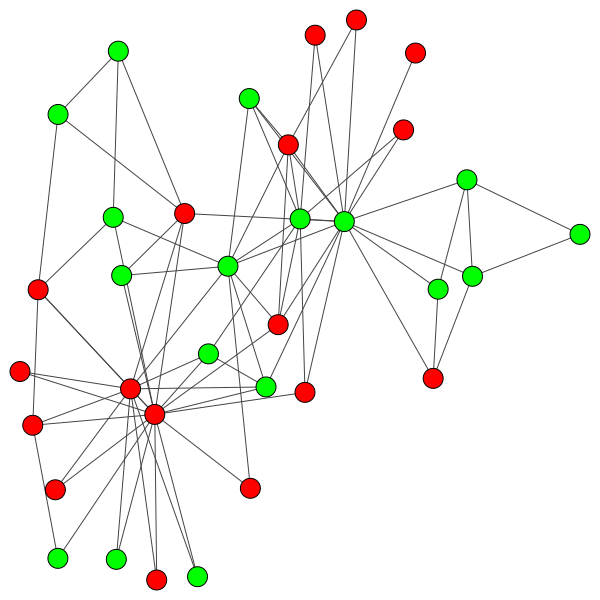

In [266]:
igraph.plot(p)

## Walktrap Closed Form

In [450]:
importlib.reload(methods)

p, mems = methods.walktrap_cf(largest)

[-0.20052596975673898, -0.20184089414858644, -0.20315581854043394, -0.20578566732412887, -0.21367521367521364, -0.2495069033530572, -0.2682445759368836, -0.2774490466798159, -0.28402366863905326, -0.492439184746877, -0.4963839579224194, -0.5003287310979618, -0.5101906640368178, -0.4658119658119657, -0.4838921761998684, -0.4891518737672583, -0.48487836949375407, -0.4937541091387245, -0.48389217619986846, -0.4858645627876397, -0.0401051939513478, -0.026955950032873113, 0.30046022353714663, 0.36193293885601585, 0.45529257067718604, 0.45200525969756733, 0.44806048652202496, 0.4789612097304405, 0.611111111111111, 0.7514792899408284, 0.7501643655489809, 0.8389217619986851, 1.0]


In [451]:
p.names

In [457]:
clust = p.as_clustering()
mems = clust.membership
largest.vs['membership'] = mems

/Users/JakeCarlson/anaconda/lib/python3.6/site-packages/igraph/clustering.py:977: Warning: non-numeric value in matrix ignored
  num_elts - n)


In [458]:
clust.summary()

'Clustering with 34 elements and 33 clusters'

In [459]:
mems

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 0,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32]

In [460]:
p.optimal_count

2

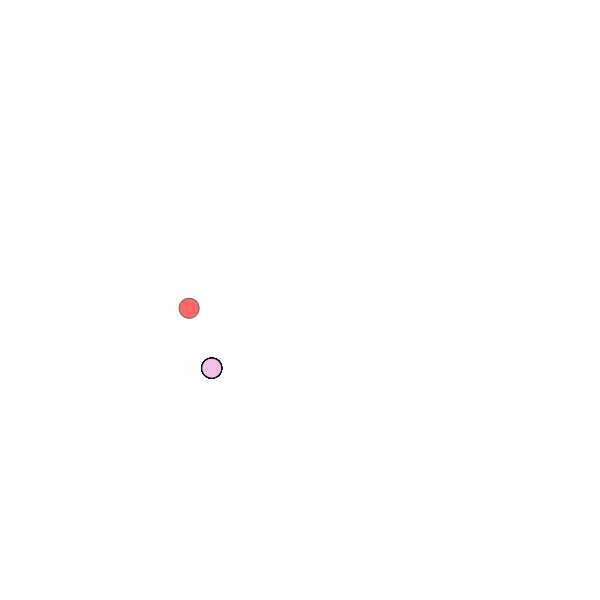

In [461]:
plot_memberships(largest, mems, clust)

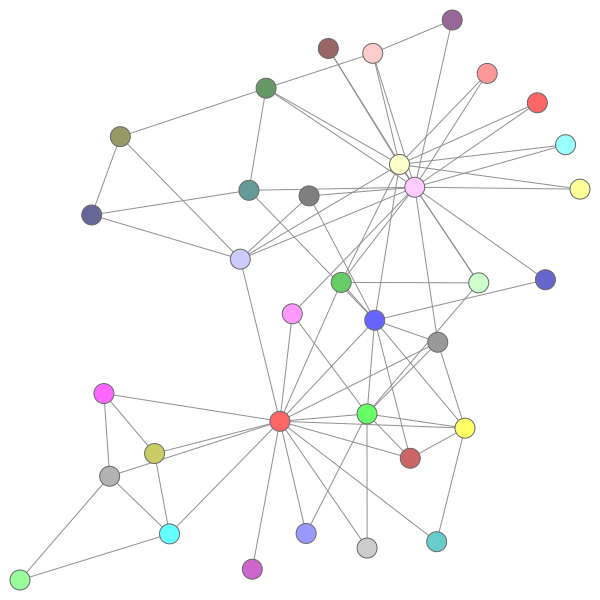

In [431]:
plot_clusters(largest, clust)

In [419]:
igraph.plot(p)

IndexError: list index out of range

## Walktrap

In [299]:
dendrogram = largest.community_walktrap()
dendrogram.optimal_count

5

In [300]:
dendrogram

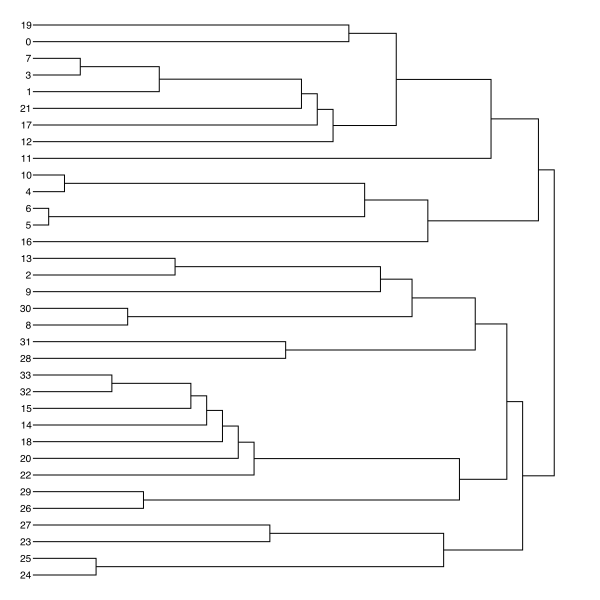

In [301]:
igraph.plot(dendrogram)

In [302]:
clusters = dendrogram.as_clustering()
membership = clusters.membership
largest.vs['membership'] = membership

In [383]:
def plot_memberships(g, ms, cls):
    palette = igraph.drawing.colors.ClusterColoringPalette(len(cls))
    colors = palette.get_many(ms)
    g.vs['color'] = colors
    layout = g.layout_auto()
    p = igraph.drawing.Plot(background='white')
    for m in range(len(set(ms))):
        p.add(cls.subgraph(m), opacity=0.6, layout=layout)
    return p

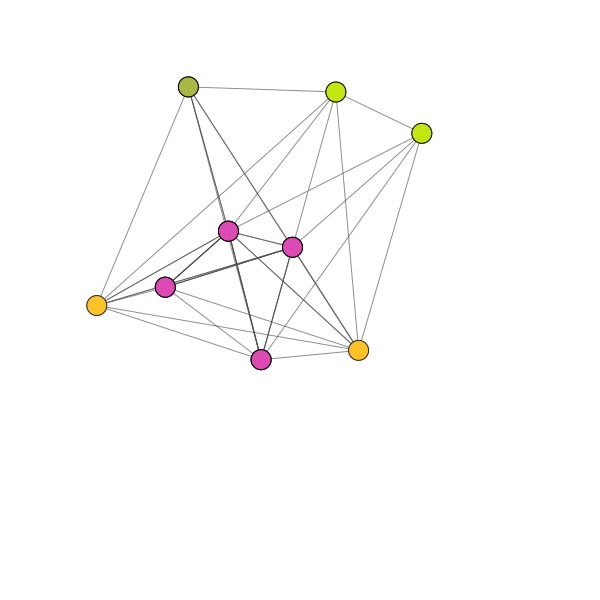

In [384]:
plot_memberships(largest, membership, clusters)

In [421]:
def plot_clusters(g, cls):
    palette = igraph.drawing.colors.ClusterColoringPalette(len(cls))
    colors = palette.get_many(cls.membership)
    g.vs['color'] = colors
    return igraph.plot(g, opacity=0.6)

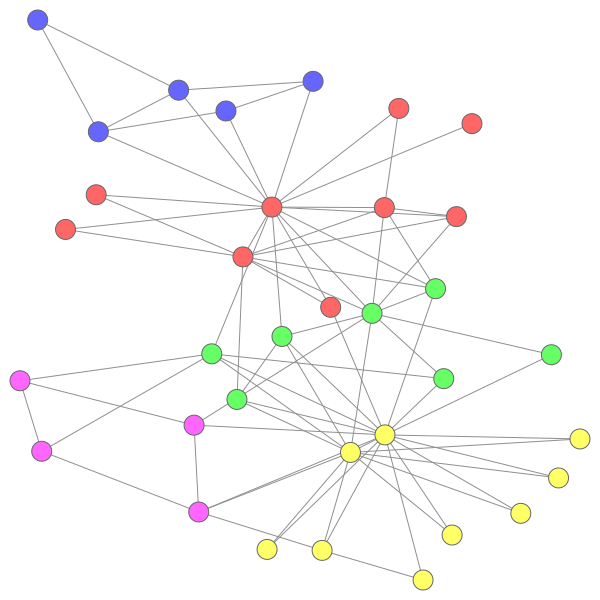

In [423]:
plot_clusters(largest, clusters)